In [220]:
import json
import pandas as pd


file_path = "Ola.json"
with open(file_path, "r", encoding="utf-8") as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data)

total_posts = len(df)

print("Total number of posts in the JSON file: ", total_posts)

Total number of posts in the JSON file:  3244


Data Cleaning and Preparation
1. Remove Duplicates.
2. Counted the number of data and converted the null in  likes, views, share to 0,
3. Convert the datetime column to a standard datetime format.

In [222]:
df = df.drop_duplicates(subset='tweet_id')
df.fillna(0, inplace=True) 
df['datetime'] = pd.to_datetime(df['datetime'], format='%d-%m-%Y %H:%M:%S')
total_posts = len(df)
print("Total number of posts in the JSON file after data cleaning: ", total_posts)

Total number of posts in the JSON file after data cleaning:  2536


We have removed all the tweet the did not include user_mentions olacabs or ola_supports

In [224]:
required_mentions = ['Olacabs', 'ola_supports']

def has_required_mentions(user_mentions):
    if user_mentions is None:
        return False
    return any(mention['screen_name'] in required_mentions for mention in user_mentions)

df = df[df['user_mentions'].apply(has_required_mentions)]
total_posts = len(df)
print("Total number of posts in the JSON file after data cleaning: ", total_posts)

Total number of posts in the JSON file after data cleaning:  1156


In [226]:
print(df.head(5))

              tweet_id                                            content  \
0  1871889326575136870  Yet again fucking driver accepted the booking ...   
1  1871076431754580058  More than 1 hour and the food is still not her...   
2  1871827021585928588  No one is constantly as motherfucking assholes...   
4  1863291107477721485  , Are you guys even concerned about what type ...   
5  1869240115614327032              Stop hiring goons to drive your cabs!   

             datetime  likes  shares  views   source  isBlue  followers  \
0 2024-12-25 12:02:48      0       0   23.0  TWITTER   False         93   
1 2024-12-23 06:12:38      2       1  107.0  TWITTER   False         72   
2 2024-12-25 07:55:13      0       0   15.0  TWITTER   False         93   
4 2024-12-01 18:36:32      0       0   32.0  TWITTER   False         47   
5 2024-12-18 04:35:47      0       0   51.0  TWITTER   False        188   

     hashtags location                                      user_mentions  \
0        

 Descriptive Analysis:
1. Calculate basic statistics (mean, median, mode) for the engagement metrics (likes,
   shares, views).
2. Identify the top 5 posts with the highest engagement (likes + shares + comments).
3. Count the number of posts with media attachments.

In [228]:
engagement = df[['likes', 'shares', 'views']]

mean = engagement.mean()
median = engagement.median()
mode = engagement.mode().iloc[0]  

print("Mean of Engagement Metrics:")
print(mean)
print("\nMedian of Engagement Metrics:")
print(median)
print("\nMode of Engagement Metrics:")
print(mode)

Mean of Engagement Metrics:
likes       38.869377
shares       5.523356
views     1167.459343
dtype: float64

Median of Engagement Metrics:
likes      0.0
shares     0.0
views     18.0
dtype: float64

Mode of Engagement Metrics:
likes     0.0
shares    0.0
views     0.0
Name: 0, dtype: float64


In [230]:
for post in data:
    post['engagement'] = post['likes'] + post['shares'] + len(post['comments'])

sorted_posts = sorted(data, key=lambda x: x['engagement'], reverse=True)

top_5_posts = sorted_posts[:5]

for idx, post in enumerate(top_5_posts, 1):
    print(f"Top {idx} Post:")
    print(f"Tweet ID: {post['tweet_id']}")
    print(f"Likes: {post['likes']} | Shares: {post['shares']} | Comments: {len(post['comments'])}")
    print(f"Total Engagement: {post['engagement']}")
    print("-" * 50)


Top 1 Post:
Tweet ID: 1649137934841544704
Likes: 20725 | Shares: 2706 | Comments: 64
Total Engagement: 23495
--------------------------------------------------
Top 2 Post:
Tweet ID: 1758125175714021772
Likes: 2788 | Shares: 17964 | Comments: 2
Total Engagement: 20754
--------------------------------------------------
Top 3 Post:
Tweet ID: 1842896103618048240
Likes: 18664 | Shares: 1823 | Comments: 61
Total Engagement: 20548
--------------------------------------------------
Top 4 Post:
Tweet ID: 1329638961308962816
Likes: 17547 | Shares: 1069 | Comments: 66
Total Engagement: 18682
--------------------------------------------------
Top 5 Post:
Tweet ID: 1842882565209723381
Likes: 13809 | Shares: 2881 | Comments: 77
Total Engagement: 16767
--------------------------------------------------


 Checks if media field exists and is not empty

In [232]:
posts_media = sum(1 for tweet in data if tweet.get('media'))  
print(f"Number of posts with media attachments: {posts_media}")

Number of posts with media attachments: 1037


 Sentiment Analysis:
1. Perform sentiment analysis on the post content using a sentiment analysis library
   (e.g., TextBlob or VADER).
2. Categorize posts into Positive, Neutral, or Negative sentiment.
3. Calculate the percentage of posts in each sentiment category.

install pip install textblob

We are performing Sentiment Analysis: Evaluates the sentiment (positive, neutral, or negative) of a piece of text.
using textblob

In [234]:
import pandas as pd
from textblob import TextBlob

def analyze_sentiment(content):
    blob = TextBlob(content)
    return blob.sentiment.polarity  

df['sentiment_polarity'] = df['content'].apply(analyze_sentiment)

def classify_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df['sentiment_category'] = df['sentiment_polarity'].apply(classify_sentiment)

sentiment_counts = df['sentiment_category'].value_counts(normalize=True) * 100

print("Sentiment Analysis Results:")
print(sentiment_counts)

Sentiment Analysis Results:
sentiment_category
Neutral     34.861592
Positive    34.515571
Negative    30.622837
Name: proportion, dtype: float64


In [236]:
print(df[['sentiment_category', 'sentiment_polarity']].head(6))

  sentiment_category  sentiment_polarity
0           Negative              -0.600
1           Positive               0.250
2           Negative              -0.375
4           Positive               0.100
5            Neutral               0.000
6           Negative              -0.500


install pip install vaderSentiment

We are performing Sentiment Analysis using VADER

In [238]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(content):
    score = analyzer.polarity_scores(content)
    return score['compound'] 
    
df['sentiment_polarity'] = df['content'].apply(analyze_sentiment)

def classify_sentiment(polarity):
    if polarity >= 0.05:
        return "Positive"
    elif polarity <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment_category'] = df['sentiment_polarity'].apply(classify_sentiment)
sentiment_counts = df['sentiment_category'].value_counts(normalize=True) * 100
print("Sentiment Analysis Results:")
print(sentiment_counts)


Sentiment Analysis Results:
sentiment_category
Negative    43.079585
Positive    37.370242
Neutral     19.550173
Name: proportion, dtype: float64


In [240]:
print(df[['sentiment_category', 'sentiment_polarity']].head(6))

  sentiment_category  sentiment_polarity
0           Negative             -0.7115
1           Negative             -0.1010
2           Negative             -0.9442
4            Neutral              0.0000
5           Negative             -0.3595
6           Negative             -0.7579


By analysing both textblob and VADER we can conclude that it gives nearly approx result for the sentiment analysis

  Customer Complaints:
 1. Extract posts mentioning complaints about drivers, booking cancellations, or customer
     service issues.
 2. Categorize these posts based on the type of complaint.
 3. Visualize the distribution of complaint categories using a bar chart.

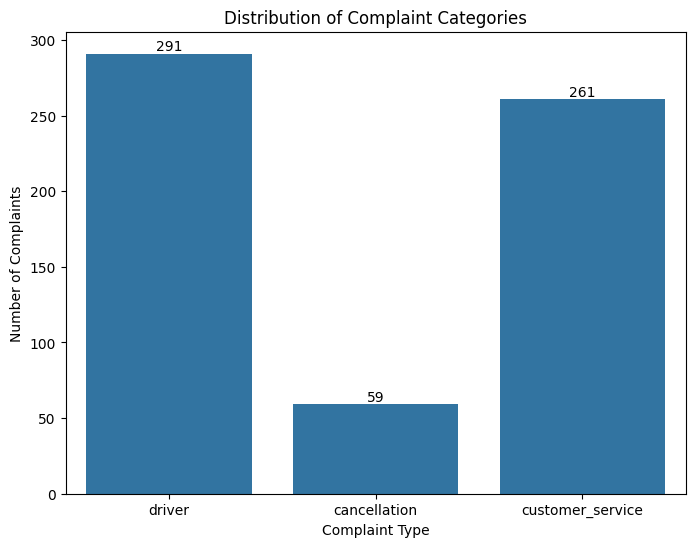

In [242]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

complaints_keywords = {
    'driver': [
        'driver', 'poor driver', 'rude driver', 'late driver', 'waste', 'bad',
        'rude', 'unprofessional', 'aggressive', 'reckless', 'inappropriate', 
        'unsafe', 'late', 'cancel', 'refuse', 'reject', 'asshole', 'moron', 
        'idiot', 'disrespectful', 'careless', 'disorganized', 'unreliable', 
        'horrible driver', 'incompetent driver', 'unqualified', 'terrible driver',
        'scammer', 'liar', 'disappointing driver', 'annoying driver', 'non-compliant',
        'drunken driver', 'violent driver', 'reckless driver'
    ],
    'cancellation': [
        'booking cancelled', 'cancellation', 'cancelled booking', 'cancel', 
        'cancelled', 'cancelling', 'cancellation', 'reject', 'rejected', 
        'rejecting', 'rejection', 'refuse', 'refused', 'refusing', 'refusal',
        "didn't come", "not show up", "no show", "turned down", "declined", 
        'booking not confirmed', 'no confirmation', 'change of plans', 'unresponsive', 
        'denied booking', 'cancellation policy', 'cancelled trip', 'trip not available',
        'booking failed', 'cancellation charge', 'refund issue', 'cancellation fee',
        'unavailable', 'not confirmed', 'cancelled order', 'booking unavailable'
    ],
    'customer_service': [
        'customer service', 'bad service', 'service issues', 'issue', 'customer service', 
        'customer support', 'help center', 'support team', 'care', 'unhelpful', 'useless', 
        'inefficient', 'slow', 'long wait', 'no response', 'no reply', 'ignored', 'rude', 
        'unprofessional', 'pathetic', 'horrible', 'terrible', 'bad experience', 'poor service', 
        'didn\'t help', 'not helpful', 'hangup', 'hang up', 'no assistance', 'unresponsive', 
        'failed to assist', 'terrible support', 'unavailable support', 'misleading support', 
        'customer negligence', 'unfriendly', 'uncooperative', 'confusing', 'unavailable agent', 
        'untrained staff', 'unqualified support', 'miscommunication', 'impatient service', 
        'lack of follow-up', 'unsatisfactory service', 'no resolution', 'ignored complaint', 
        'unresolved issue', 'unhelpful staff', 'delayed response', 'dissatisfied with service', 
        'poor customer experience', 'no solution', 'bad customer experience', 'unresolved case'
    ]
}
def filter_complaints(content, keywords):
    complaint_type = []
    
    # Check for each complaint type
    for complaint, terms in keywords.items():
        for term in terms:
            if term.lower() in content.lower():
                complaint_type.append(complaint)
                break
    return complaint_type if complaint_type else None

df['complaints'] = df['content'].apply(lambda x: filter_complaints(x, complaints_keywords))

complaint_posts = df[df['complaints'].notnull()]

complaint_categories = complaint_posts['complaints'].explode()

plt.figure(figsize=(8, 6))
ax = sns.countplot(x=complaint_categories)
ax.bar_label(ax.containers[0])
plt.title('Distribution of Complaint Categories')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.show()


From the bar graph, we can conclude that there are more complaints about driver behavior and customer service.
Below we can see that a colunm is add called complaints, categorised into driver, cancellation, coustomer_service.

In [255]:
print(df.dtypes)
print(df.head(5))

tweet_id                      object
content                       object
datetime              datetime64[ns]
likes                          int64
shares                         int64
views                        float64
source                        object
isBlue                          bool
followers                      int64
hashtags                      object
location                      object
user_mentions                 object
media                         object
username                      object
url                           object
comments                      object
sentiment_polarity           float64
sentiment_category            object
complaints                    object
comments_len                   int64
total                          int64
dtype: object
              tweet_id                                            content  \
0  1871889326575136870  Yet again fucking driver accepted the booking ...   
1  1871076431754580058  More than 1 hour and the food i

Engagement Analysis:

1. Determine the correlation between the number of followers and the engagement
   metrics (likes, shares, comments).
2. Identify any patterns in engagement based on the source of posts (e.g., Twitter,
   Instagram, etc.).

In [246]:
df["comments_len"] = df["comments"].apply(len)

correlations = df[["followers", "likes", "shares", "comments_len"]].corr()
print("Correlations:")
print(correlations)



source_eng = df.groupby("source")[["likes", "shares", "comments_len"]].mean()

print("\nEngagement metrics by source:")
print(source_eng)

Correlations:
              followers     likes    shares  comments_len
followers      1.000000  0.075688  0.105585      0.133691
likes          0.075688  1.000000  0.814000      0.526112
shares         0.105585  0.814000  1.000000      0.609832
comments_len   0.133691  0.526112  0.609832      1.000000

Engagement metrics by source:
             likes    shares  comments_len
source                                    
TWITTER  38.869377  5.523356      1.364187


Total engagement like + shares + comments correlation between followers

In [248]:
df["total"] = df["likes"] + df["shares"] + df["comments"].apply(len)

correlation = df[["followers", "total"]].corr().iloc[0, 1]

print(f"Correlation between number of followers and total engagement: {correlation:.2f}")

Correlation between number of followers and total engagement: 0.08


 Recommendations:
1. Based on your findings, propose three actionable recommendations for Ola Cabs to
   improve their customer experience and social media engagement.

1. To Improve Customer Experience
  a. Driver Training: Regularly train drivers on customer etiquette and conflict resolution.
  b. Incentivize Good Behavior: Recognize and reward drivers with consistently positive feedback.
  c. Stricter Screening: Perform thorough background checks and psychometric evaluations during driver onboarding.
  d. Feedback System: Promptly act on customer feedback with transparent communication about resolution outcomes.

2. To Improve Social Media Engagement
  a. Engagement Campaigns: Launch campaigns encouraging customers to share their positive experiences with hashtags, offering rewards for the best           stories.
  b. Feedback Integration: Use social media data to refine operations, addressing frequent complaints and building features customers desire.

3. To Improve Booking and Ride Experience
  a. Ensure Reliability: Reduce ride cancellations by implementing penalties for drivers who cancel without valid reasons and reward those with high         completion rates.
  b. Real-Time Updates: Provide real-time tracking of rides and estimated arrival times with high accuracy.

Converted the clean data to csv

In [250]:
csv_file_path = "cleaned_data.csv"  
df.to_csv(csv_file_path, index=False)
print(f"Cleaned data has been saved as '{csv_file_path}'.")

Cleaned data has been saved as 'cleaned_data.csv'.
